In [104]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
from PIL import Image

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader

In [105]:
# Create data directory if it doesn't exist
os.makedirs('../data', exist_ok=True)

In [106]:
# Define transformations for training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize the images with ImageNet mean and std since we are using ResNet which is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [107]:
# Load the dataset
print("Loading dataset...")
train_dataset = OxfordIIITPet(root='../data', 
                             split='trainval',
                             target_types="category",
                             transform=transform,
                             download=True)

test_dataset = OxfordIIITPet(root='../data', 
                           split='test',
                           target_types="category",
                           transform=transform,
                           download=True)

Loading dataset...


In [158]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [159]:
# torchvision.models.wide_resnet50_2(weights='IMAGENET1K_V2')

In [160]:
# CAM Model using ResNet backbone
class CAMModel(nn.Module):
    def __init__(self, num_classes=37):  # Oxford-IIIT Pet has 37 categories
        super(CAMModel, self).__init__()
        # Load a pre-trained ResNet
        self.resnet = torchvision.models.resnet50(weights='IMAGENET1K_V2')
        # self.resnet = torchvision.models.wide_resnet50_2(weights='IMAGENET1K_V2')  # for a wider ResNet
        
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(self.resnet.children())[:-2]) # for last Conv layer
        # self.features = nn.Sequential(*list(self.resnet.children())[:-3]) # for 2nd to last Conv layer
        
        # Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Classification layer
        # self.fc = nn.Linear(1024, num_classes)  # 1024 is output channels for ResNet-50 in the 2nd to last Conv layer, which is a 1024x14x14 image
        self.fc = nn.Linear(2048, num_classes)  # 2048 is output channels for ResNet-50 in the last Conv layer, which is a 2048x7x7 image
    
    def forward(self, x):
        # Feature extraction
        features = self.features(x)
        
        # Save features for CAM generation
        self.last_features = features
        
        # Global Average Pooling
        x = self.gap(features)
        x = x.view(x.size(0), -1)
        
        # Classification
        x = self.fc(x)
        return x

In [161]:
def train_model(model, train_loader, num_epochs=5):
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    print(f"Training on {device}...")

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

    # Save the model checkpoint
    torch.save(model.state_dict(), './models/cam_model.pth')
    return model

In [162]:
print("Creating model...")
model = CAMModel()
if not os.path.exists('./models/'): os.mkdir('./models')
# Set to True if you want to train, False to load pre-trained
TRAIN_MODEL = True

if TRAIN_MODEL:
    model = train_model(model, train_loader, num_epochs=5)
else:
    # Load pretrained model if it exists
    if os.path.exists('./models/cam_model.pth'):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load('./models/cam_model.pth', map_location=device, weights_only=False))
        model = model.to(device)
        print("Loaded pre-trained model")
    else:
        print("No pre-trained model found, training new model")
        model = train_model(model, train_loader, num_epochs=5)

Creating model...
Training on cuda...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch [1/5], Loss: 1.3506, Accuracy: 60.95%


Epoch 2/5:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch [2/5], Loss: 0.6653, Accuracy: 79.27%


Epoch 3/5:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch [3/5], Loss: 0.3957, Accuracy: 87.64%


Epoch 4/5:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch [4/5], Loss: 0.2570, Accuracy: 91.55%


Epoch 5/5:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch [5/5], Loss: 0.2112, Accuracy: 93.32%


In [163]:
model

CAMModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [164]:
def generate_cam(model, img, label):
    """
    Generate Class Activation Map for an image.
    
    Args:
        model: The trained model with CAM capability
        img_tensor: Preprocessed image tensor
        label: Class label for which to generate CAM
    
    Returns:
        CAM numpy array
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Forward pass
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
    
    # Get weights from the final FC layer for the specified class
    fc_weights = model.fc.weight[label].cpu()
    
    # Get feature maps from the last convolutional layer
    feature_maps = model.last_features.squeeze(0).cpu()
    print(feature_maps.min())
    # Calculate weighted sum of feature maps
    print(fc_weights.shape, feature_maps.shape)
    cam = (fc_weights[:, None, None] * feature_maps).sum(0)
    cam = torch.sigmoid(1*cam)
    
    # cam = (cam - cam.min())/cam.max()
    # Apply ReLU and normalize
    # cam = torch.maximum(cam, torch.tensor(0.0))
    # if cam.max() > 0:
    #     cam = cam / cam.max()
    
    # Convert to numpy and resize
    cam = cam.detach().numpy()
    print(cam.shape)
    return cam

In [165]:
def plot_cam_overlay(img, cam, label=None):
    """
    Plot image with CAM overlay.
    
    Args:
        img: Original image as numpy array (H,W,C) with RGB channels
        cam: Resized CAM numpy array (same H,W as img)
        label: Optional label to display in title
    """
    # Convert CAM to heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Create overlay (60% original image, 40% heatmap)
    overlay = np.uint8(0.6 * img + 0.4 * heatmap)
    
    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    if label is not None:
        plt.title(f'Class: {label}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


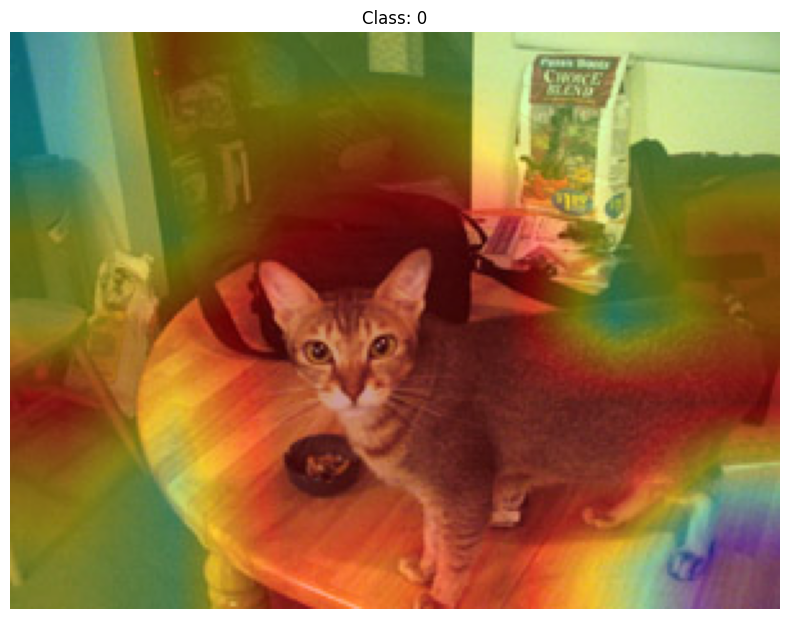

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


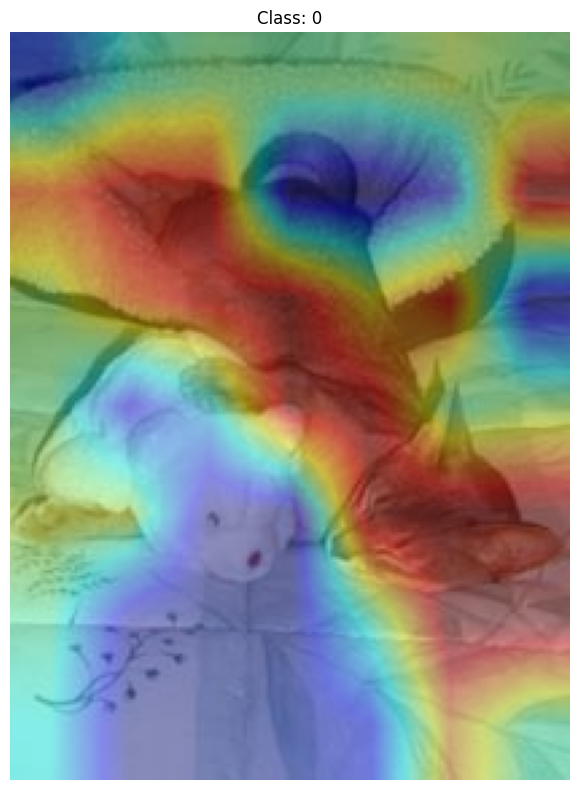

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


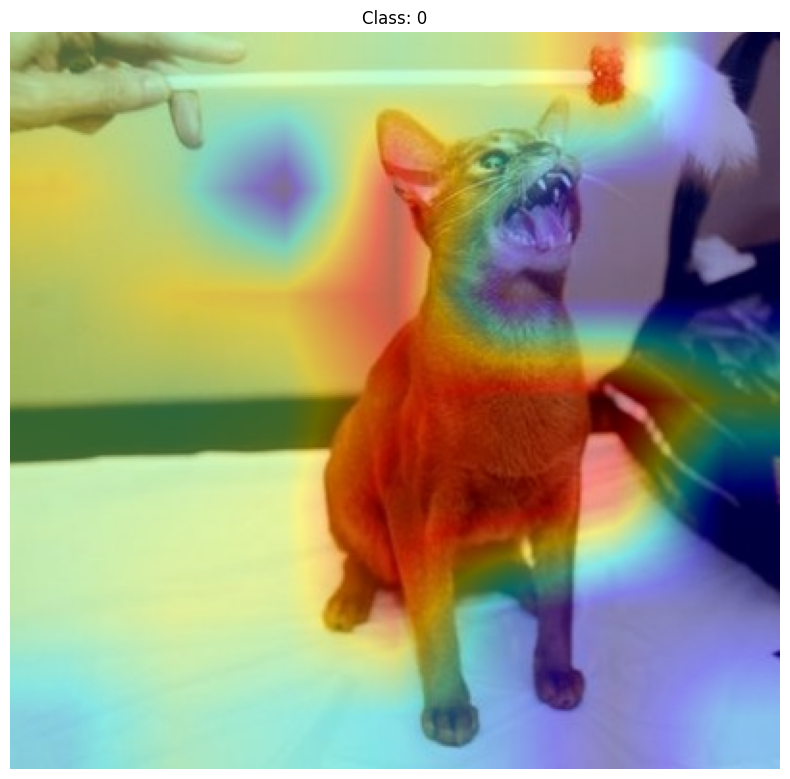

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


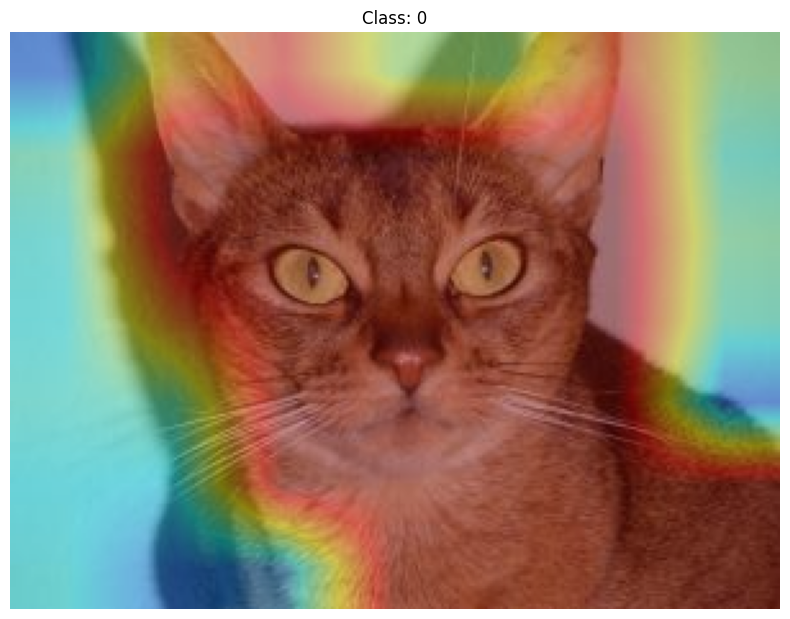

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


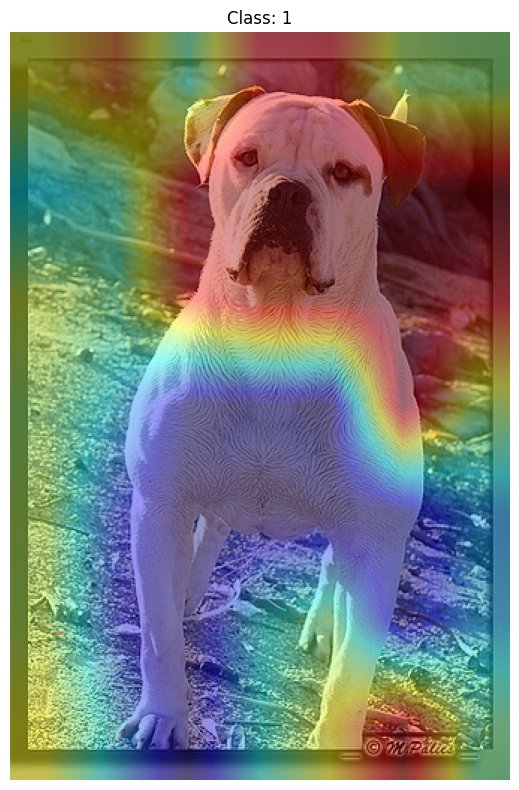

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


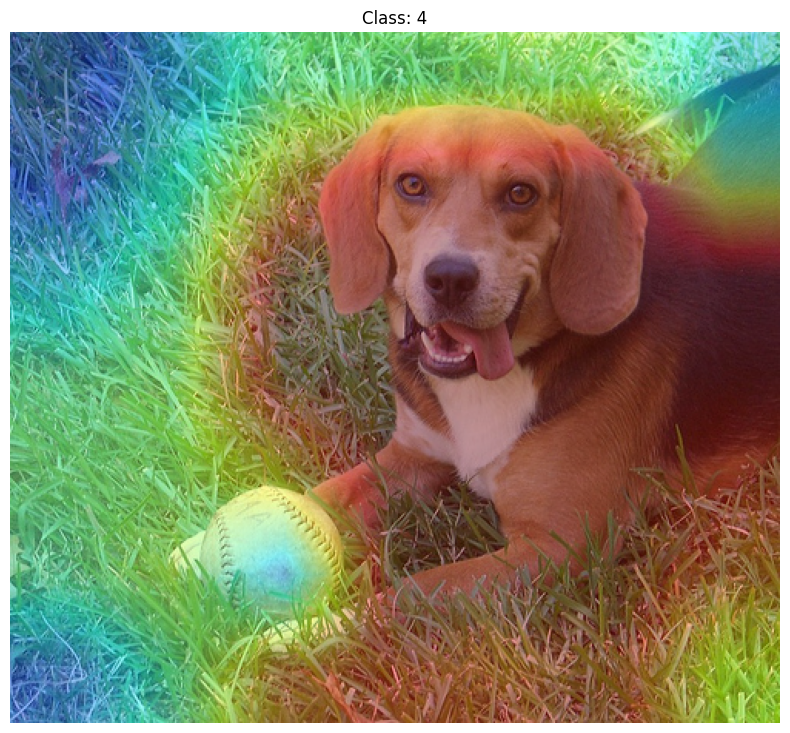

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


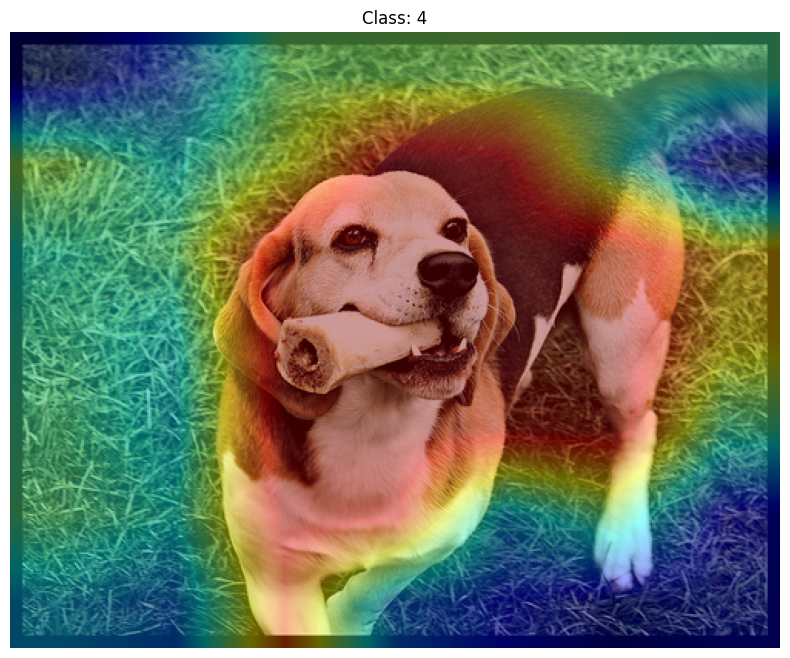

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


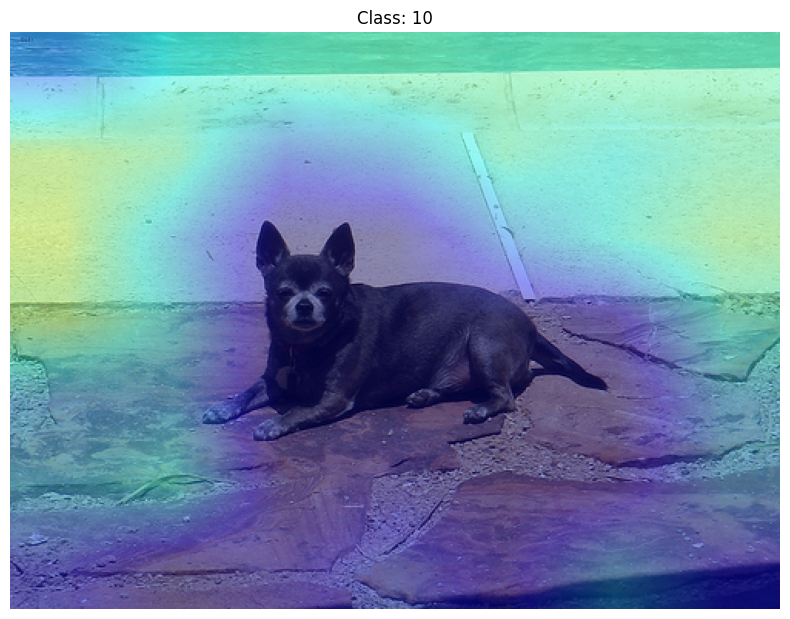

tensor(0.)
torch.Size([2048]) torch.Size([2048, 7, 7])
(7, 7)


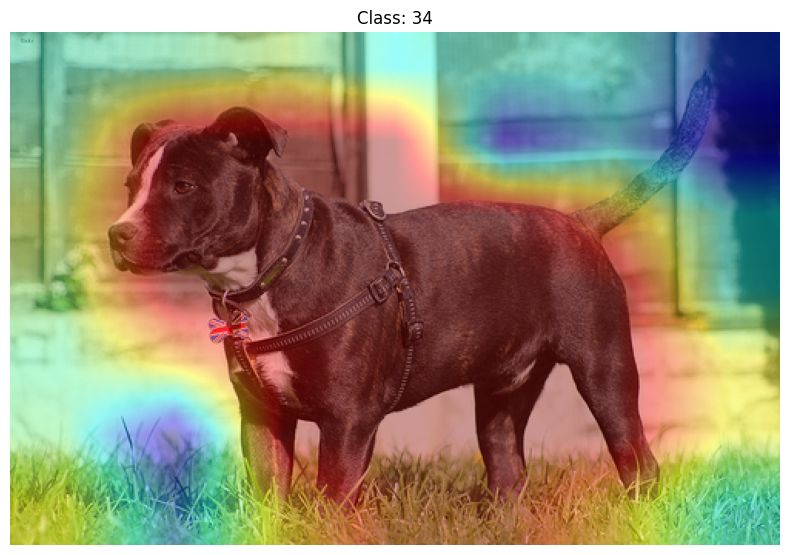

In [166]:
# idx = 500 # Change this index to visualize different images

for idx in [0, 5, 6, 11, 121, 422, 434, 1001, 3434]:

    # Get image and label from dataset
    img, label = test_dataset[idx]

    # Get original image
    img_path = test_dataset._images[idx]
    original_img = Image.open(img_path).convert('RGB')
    original_np = np.array(original_img)

    # Generate CAM
    cam = generate_cam(model, img, label)

    # Resize CAM to match original image size
    # interpolation selection https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html
    cam_resized = cv2.resize(cam, original_img.size, interpolation=1)

    # Plot overlay
    plot_cam_overlay(original_np, cam_resized, label)